In [1]:
bucket = 'arch-ml-bucket-us-east-1'
prefix = 'mall_customer'

!pip install mxnet

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role
import os
import pandas as pd
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker.predictor import csv_serializer, json_deserializer
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
from scipy.spatial.distance import cdist
%matplotlib inline

  Using cached https://files.pythonhosted.org/packages/e5/c4/395ebb218053ba44d64935b3729bc88241ec279915e72100c5979db10945/numpy-1.14.6-cp36-cp36m-manylinux1_x86_64.whl
fastai 1.0.50.post1 requires nvidia-ml-py3, which is not installed.
thinc 6.12.1 has requirement msgpack<0.6.0,>=0.5.6, but you'll have msgpack 0.6.0 which is incompatible.
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.50.post1 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
role = get_execution_role()

# Upload training data to S3

In [9]:
def write_to_s3(filename):
    with open(filename,'rb') as f: # Read in binary mode
        return boto3.Session().resource('s3').Bucket(bucket)\
            .Object(os.path.join(prefix, filename)).upload_fileobj(f)

In [10]:
write_to_s3('train.csv')

# Train

In [11]:
image_name = get_image_uri(boto3.Session().region_name, 'kmeans')

In [13]:
image_name

'382416733822.dkr.ecr.us-east-1.amazonaws.com/kmeans:1'

In [23]:
# Model params
feature_dim = 2
K = range(2, 12)

# Infrastructure parmas
INSTANCE_COUNT = 1
run_parallel_jobs = True
instance_type = 'ml.m4.xlarge'
base_job_name = 'kmeans-mall-v2'
train_data_path = 's3://{}/{}/{}'.format(bucket, prefix, 'train.csv')

job_names = []
for k in K:
    print('Starting train job for cluster {}'.format(k))
    
    output_path = 's3://{}/{}/{}'.format(bucket, prefix, base_job_name)
    print('Trained Artifacts will be uploaded to {}'.format(output_path))
    
    b_job_name = '{}-clusters-{}'.format(k, base_job_name)
    sess = sagemaker.Session()
    estimator = sagemaker.estimator.Estimator(
        image_name=image_name,
        role=role,
        train_instance_count=INSTANCE_COUNT,
        train_instance_type=instance_type,
        output_path=output_path,
        sagemaker_session=sess,
        base_job_name=b_job_name,
    )
    
    estimator.set_hyperparameters(k=k, feature_dim=feature_dim)
    
    training_input_config = sagemaker.session.s3_input(
        s3_data=train_data_path, 
        content_type="text/csv;label_size=0",
    )
    
    # Training instance invoked
    estimator.fit(
        {'train':training_input_config}, 
        wait=not(run_parallel_jobs),
    )
    
    # Get Job Status
    boto3_sagemaker = boto3.client('sagemaker')
    job_name = estimator.latest_training_job.name    
    status = boto3_sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print(status)
    
    if not run_parallel_jobs:
        try:
            boto3_sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
        finally:
            status = boto3_sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
            print("Training job ended with status: " + status)
            if status == 'Failed':
                message = boto3_sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
                print('Training failed with the following error: {}'.format(message))
                raise Exception('Training job failed')
    
    # Return job names for status checking
    job_names.append(job_name)

INFO:sagemaker:Creating training-job with name: 2-clusters-kmeans-mall-v2-2019-05-08-04-24-53-669


Starting train job for cluster 2
Trained Artifacts will be uploaded to s3://arch-ml-bucket-us-east-1/mall_customer/kmeans-mall-v2


INFO:sagemaker:Creating training-job with name: 3-clusters-kmeans-mall-v2-2019-05-08-04-24-54-069


InProgress
Starting train job for cluster 3
Trained Artifacts will be uploaded to s3://arch-ml-bucket-us-east-1/mall_customer/kmeans-mall-v2


INFO:sagemaker:Creating training-job with name: 4-clusters-kmeans-mall-v2-2019-05-08-04-24-54-491


InProgress
Starting train job for cluster 4
Trained Artifacts will be uploaded to s3://arch-ml-bucket-us-east-1/mall_customer/kmeans-mall-v2


INFO:sagemaker:Creating training-job with name: 5-clusters-kmeans-mall-v2-2019-05-08-04-24-58-861


InProgress
Starting train job for cluster 5
Trained Artifacts will be uploaded to s3://arch-ml-bucket-us-east-1/mall_customer/kmeans-mall-v2


INFO:sagemaker:Creating training-job with name: 6-clusters-kmeans-mall-v2-2019-05-08-04-25-00-166


InProgress
Starting train job for cluster 6
Trained Artifacts will be uploaded to s3://arch-ml-bucket-us-east-1/mall_customer/kmeans-mall-v2


INFO:sagemaker:Creating training-job with name: 7-clusters-kmeans-mall-v2-2019-05-08-04-25-03-736


InProgress
Starting train job for cluster 7
Trained Artifacts will be uploaded to s3://arch-ml-bucket-us-east-1/mall_customer/kmeans-mall-v2


INFO:sagemaker:Creating training-job with name: 8-clusters-kmeans-mall-v2-2019-05-08-04-25-04-008


InProgress
Starting train job for cluster 8
Trained Artifacts will be uploaded to s3://arch-ml-bucket-us-east-1/mall_customer/kmeans-mall-v2


INFO:sagemaker:Creating training-job with name: 9-clusters-kmeans-mall-v2-2019-05-08-04-25-07-167


InProgress
Starting train job for cluster 9
Trained Artifacts will be uploaded to s3://arch-ml-bucket-us-east-1/mall_customer/kmeans-mall-v2


INFO:sagemaker:Creating training-job with name: 10-clusters-kmeans-mall-v2-2019-05-08-04-25-07-701


InProgress
Starting train job for cluster 10
Trained Artifacts will be uploaded to s3://arch-ml-bucket-us-east-1/mall_customer/kmeans-mall-v2


INFO:sagemaker:Creating training-job with name: 11-clusters-kmeans-mall-v2-2019-05-08-04-25-08-025


InProgress
Starting train job for cluster 11
Trained Artifacts will be uploaded to s3://arch-ml-bucket-us-east-1/mall_customer/kmeans-mall-v2
InProgress


In [24]:
# Print Job Status When Each of Them Is Done
while len(job_names):
    boto3_sagemaker = boto3.client('sagemaker')
    try:
        boto3_sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_names[0])
    finally:
        status = boto3_sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
        print("Training job ended with status: " + status)
        if status == 'Failed':
            message = boto3_sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
            print('Training failed with the following error: {}'.format(message))
            raise Exception('Training job failed')

    print(job_name)

    info = boto3_sagemaker.describe_training_job(TrainingJobName=job_name)
    job_names.pop(0)

Training job ended with status: Completed
11-clusters-kmeans-mall-v2-2019-05-08-04-25-08-025
Training job ended with status: Completed
11-clusters-kmeans-mall-v2-2019-05-08-04-25-08-025
Training job ended with status: Completed
11-clusters-kmeans-mall-v2-2019-05-08-04-25-08-025
Training job ended with status: Completed
11-clusters-kmeans-mall-v2-2019-05-08-04-25-08-025
Training job ended with status: Completed
11-clusters-kmeans-mall-v2-2019-05-08-04-25-08-025
Training job ended with status: Completed
11-clusters-kmeans-mall-v2-2019-05-08-04-25-08-025
Training job ended with status: Completed
11-clusters-kmeans-mall-v2-2019-05-08-04-25-08-025
Training job ended with status: Completed
11-clusters-kmeans-mall-v2-2019-05-08-04-25-08-025
Training job ended with status: Completed
11-clusters-kmeans-mall-v2-2019-05-08-04-25-08-025
Training job ended with status: Completed
11-clusters-kmeans-mall-v2-2019-05-08-04-25-08-025


# Obtain Artifacts Keys

In [29]:
def list_model_keys():
    client = boto3.client('s3')
    objects = client.list_objects(Bucket=bucket, Prefix=prefix)['Contents']
    keys = list(map(lambda x: x['Key'], objects))
    
    folder_name = '/{}/'.format(base_job_name)
    filtered = list(filter(lambda x: folder_name in x, keys))
    return filtered

In [30]:
import re 

def cluster_key():
    clusters = {}
    
    for key in list_model_keys():
        parent_path = '{}/{}'.format(prefix, base_job_name)        
        cluster = re.search('^{}/(.*)-cluster'.format(parent_path), key)
        cluster = cluster.group(1)
        clusters[cluster] = key
        
    return clusters

# Find Optimal K (No. Of Clusters)

In [9]:
# K = range(2, 12)
# base_job_name = 'kmeans-mall-v2'

def centroids_and_distortions(train_df):
    centroids = {}
    distortions = []
    for k in K:
        key = cluster_key()[str(k)]

        s3_client = boto3.client('s3')
        s3_client.download_file(bucket, key, 'model.tar.gz')

        !tar -xvf model.tar.gz                       
        kmeans_model=mx.ndarray.load('model_algo-1')
        kmeans_numpy = kmeans_model[0].asnumpy()

        distortions.append(sum(np.min(cdist(train_df, kmeans_numpy, 'euclidean'), axis=1)) / train_df.shape[0])
        centroids[k] = kmeans_numpy
    
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    
    return (centroids, distortions)

state_d3989618-e182-4755-8444-faedd6860883
model_algo-1
state_0fb9d067-1986-4699-98b0-cf4510d5403d
model_algo-1
state_ca98644a-ec9e-414e-8c7a-b62919265343
model_algo-1
model_algo-1
state_d89707b7-819b-46a1-af85-fa5a7ab0ecbc
model_algo-1
state_af6219a4-5611-45c4-a489-702d328e5351
model_algo-1
state_abc6fc4f-5d87-4b9e-869d-9a63952ca989
state_842cd341-36b6-4bde-a404-b7805ce17b52
model_algo-1
model_algo-1
state_d2617333-9323-4861-adf8-c63100158199
state_eecda31f-72a2-44a2-99eb-687b29f9ae01
model_algo-1
state_616fd13f-47b7-4970-b75d-fa1391501167
model_algo-1


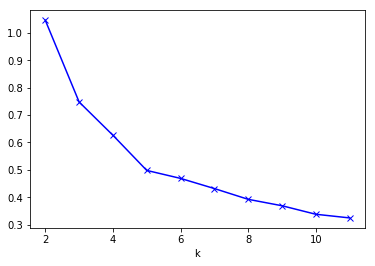

In [10]:
(centroids, distortions) = centroids_and_distortions(pd.read_csv('train.csv'))

In [11]:
import pickle

with open('centroids.pkl', 'wb') as f:
    pickle.dump(obj=centroids, file=f)
    
with open('distortions.pkl', 'wb') as f:
    pickle.dump(obj=distortions, file=f)

# Pick Optimal K = 5

In [12]:
centroids[5]

array([[ 0.9531139 ,  1.229772  ],
       [-0.25545475,  0.00926963],
       [ 1.0116891 , -1.2399268 ],
       [-1.3558912 ,  1.1209366 ],
       [-1.3140463 , -1.2060565 ]], dtype=float32)

In [24]:
with open('centroids.optimal.pkl', 'wb') as f:
    pickle.dump(obj=centroids[5], file=f)

In [39]:
with open('model_info.optimal.txt', 'w') as f:
    f.write(cluster_key()['5'])
    f.write('\n')
    f.write('382416733822.dkr.ecr.us-east-1.amazonaws.com/kmeans:1')

In [ ]:
'382416733822.dkr.ecr.us-east-1.amazonaws.com/kmeans:1'